### Data Center Siting Relative to Electricity Infrastructure and Water Resources in Texas Using Geospatial Methods

Shalini Das
<br> GGIS 403 (Fall 2025)

### I. Introduction

<br> Across water-stressed regions such as Texas, there has been a significant rise in the siting of large and hyperscale data centers due to the comparative advantages in land costs and economic development incentives. The accelerated demand for electricity generation and computing driven by corporate interests in artificial intelligence has heightened concerns about freshwater usage and energy consumption. As a result, these expansion projects have raised critical questions in both academic and policy contexts about the disparate social and environmental implications of data center siting patterns.
<br>
<br>Methods that will be implemented in this analysis include using Python’s `requests` library to fetch data from Open-Meteo and the U.S.Energy Information Administration‘s public API services. In order to determine spatial dependence of key predictor variables, such as wet bulb temperatures, datacenter power capacity, or electricity generation totals by fuel type, I will conduct statistical tests including Moran’s I, LISA, geographically weighted regression using `geopandas`, `PySAL`, `esda`. To further support my research of data center siting trends in water-stressed regions, I will use `sklearn` for spatial modeling techniques, such as spatial hierarchical clustering or random forest regression, to identify and visualize clusters geographically with similar infrastructural and socioeconomic profiles. <br>
<br>1)  How do Texas data center water consumption patterns (WUE) vary spatially across ERCOT wind and solar generation zones,  and do facilities in water-stressed regions experience higher environmental burdens than their water-secure counterparts? <br> 
2)  Where do low water stress and strong grid coverage areas converge, if any, and how do underlying electricity generation fuel mix advantages align with data center siting patterns? <br> 
3) To what extent are environmental costs from data center water consumption disproportionately concentrated in counties with elevated socioeconomic vulnerability indicators?


In [1]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import contextily as ctx
import geopandas as gpd
import libpysal as ps 
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from shapely.geometry import Point, polygon, box
import rasterio
import raster4ml
import requests
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

<u> Related Literature </u>
<br>Some studies have begun to examine the relationship between fresh water utilization and cooling systems for electricity generation using water usage effectiveness (WUE) metrics and spatial analysis techniques, although typically at coarser resolutions using large EPA eGRID sub regions (Sen Gupta et al., 2024). Prior research has focused on specific differing use-cases of WUE, such as to estimate the impact of LLM prompt operations by datacenters in 11 African countries on local water resources (Shumba, Tshekiso, Li, Fanti, and Ren, 2025). Most recently, Arzumanyan et al. (2025) performed normalization of spatial variables and random forest model in the context of [] and found that data centers in Texas were concentrated within metropolitan regions due to the proximity of essential energy infrastructure grids and fiber networks, yet did not assess whether actual siting patterns occurs equitably or disproportionately impacts water-stressed and resource-constrained regions. <br>
<br>This project aims to contribute to existing literature by developing a geospatial dataset incorporating weather-based WUE/water and electricity generation fuel mix data wit,  to evaluate implications of data center siting in Texas.
<br>
<br> <u> Data Sources </u> 
* Data Center Locations and Attributes: Retrieved 382 of 392 data center locationfrom datacentermaps.com
* Electricity Generating Power Plant Locations: Retrieved latitude and longitude coordinates using 'plantid' and 'plantName' as index to estimate geographic impact of  Fuel Mix (EIA 930) data within specific counties/regions and how this may correspond with data center siting once aggregated/preprocessed.
* Fuel Energy Mix Data: Sourced from Form EIA-923 Monthly Generation by Energy Source, filtered by Balancing Authority/Form Respondent and selected: ERCOT (Electric Reliability Council of Texas), EPE (El Paso Electric Company), SWPP (Southwest Power Pool for Southeastern Texas bordering Louisiana), and (TEX). 
* Weather Data: Retrieved hourly temperature, humidity, and precipitation, wet bulb temperature at coordinates retrieved for datacenter locations from July 1, 2022 through July 31, 2025 (37 month period). 
* ERCOT Zone Data: Incorporated in order to join and standardize data from disparate sources across a common geographic unit (counties), and then perform spatial operations in order to perform analysis across distinct regulatory/regional entities in Texas.


#### A) Data Center Coordinates

In [2]:
# Load Datacenters csv from scraped and cleaned data using 'scrape_datacenters.py' and 'clean_datacenters.py'
datacenters = pd.read_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/texas_datacenters_final_clean.csv")
datacenters['whitespace_ratio'] = datacenters['whitespace_sqft'] / datacenters['building_size_sqft']
datacenters = datacenters.dropna(subset=['latitude', 'longitude'])
# Convert to datacenters.csv to GeoDataFrame
geometry = [Point(xy) for xy in zip(datacenters['longitude'], datacenters['latitude'])]
tx_datacenters_gdf = gpd.GeoDataFrame(datacenters, geometry=geometry, crs='EPSG:4326') #EPSG is the World Geodetic System 1984 (WGS 84) per EP

In [3]:
#Load ERCOT Wind and Solar Zones to County Mapping
ercot_wind_zones_to_county = pd.read_excel("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/ERCOT Wind Regions to County Mapping.xlsx")
ercot_solar_zones_to_county = pd.read_excel("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/ERCOT Solar Regions to County Mapping.xlsx")
# Merge Wind and Solar Zones to County Mapping
counties = pd.merge(ercot_wind_zones_to_county, ercot_solar_zones_to_county, on='County', how='outer')
counties = counties.drop_duplicates(subset=['County'])
counties = counties[['County', 'Solar Region', 'Wind Region']]
counties = counties.rename(columns={'County': 'county'})

# Load County shapefile
tx_counties = gpd.read_file('/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/geojson-counties-fips.json')
tx_counties = tx_counties[tx_counties['STATE'] == '48'] #Filter to Texas only)

# Spatial Join Datacenters with Counties
datacenters_counties = gpd.sjoin(tx_datacenters_gdf, tx_counties, how='left', predicate='within')
datacenters_counties = datacenters_counties.rename(columns={'NAME': 'county', 'name':'datacenter'})
datacenters_counties = datacenters_counties.merge(counties, on='county', how='left')
datacenters_counties = datacenters_counties[['datacenter', 'operator', 'address', 'city', 'postal_code', 'county', 'Solar Region', 'Wind Region', 'power_capacity_mw', 'building_size_sqft', 'whitespace_sqft', 'whitespace_ratio', 'geometry', 'latitude', 'longitude']]
datacenters_counties

,datacenter,operator,address,city,postal_code,county,Solar Region,Wind Region,power_capacity_mw,building_size_sqft,whitespace_sqft,whitespace_ratio,geometry,latitude,longitude
0,Datacenter Park - Dallas,Follow on LinkedIn,900-908 Quality Way,Richardson,75081.0,Dallas,CenterEast,North,NaN,NaN,NaN,NaN,POINT (-96.71217 32.96608),32.966085,-96.712168
1,Digital Realty Garland Campus,Follow on LinkedIn,1702 W Campbell Rd / 1502 Ferris Rd / 1505 Fer...,Garland,75044.0,Dallas,CenterEast,North,NaN,NaN,NaN,NaN,POINT (-96.65048 32.9771),32.977103,-96.650478
2,908 Quality Way (DFW20),Follow on LinkedIn,908 Quality Way,Richardson,75081.0,Dallas,CenterEast,North,10.0,NaN,38000.0,NaN,POINT (-96.70999 32.96622),32.966215,-96.709990
3,904 Quality Way (DFW21),Follow on LinkedIn,904 Quality Way,Richardson,75081.0,Dallas,CenterEast,North,NaN,NaN,62600.0,NaN,POINT (-96.71115 32.96625),32.966249,-96.711150
4,1702 W Campbell Rd,Follow on LinkedIn,1702 W Campbell Rd,Garland,75044.0,Dallas,CenterEast,North,NaN,NaN,NaN,NaN,POINT (-96.65048 32.9771),32.977103,-96.650478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Lumen El Paso 2,Lumen,201 E Main Drive,El Paso,79901,NaN,NaN,NaN,NaN,3810.0,NaN,NaN,POINT (-106.48845 31.7603),31.760298,-106.488455
378,Lumen El Paso 1,Lumen,501 W. Overland,El Paso,79936,NaN,NaN,NaN,NaN,20000.0,NaN,NaN,POINT (-106.49339 31.75585),31.755853,-106.493388
379,Project Dorothy I,Soluna Computing,9985 Co Rd F,Silverton,79257,Briscoe,NorthWest,Panhandle,286.0,NaN,NaN,NaN,POINT (-101.31759 34.39229),34.392291,-101.317591
380,Duos Edge AI - Pampa,"Duos Edge AI, Inc.","Pampa Energy Center, 8201 Fm 2300",Pampa,79065,Gray,NorthWest,Panhandle,50.0,NaN,NaN,NaN,POINT (-101.04402 35.48546),35.485458,-101.044017


In [4]:
def classify_datacenters_by_power_size(power_capacity_mw):
    if power_capacity_mw is None or pd.isna(power_capacity_mw):
        return 'Missing Data'

    # Check if power_capacity_mw is within reasonable bounds
    if power_capacity_mw < 0.075:  # Minimum realistic datacenter (your data shows 0.075 MW)
        return "Unrealistic (Too Small)"
    elif power_capacity_mw > 800:  # Maximum in your dataset
        return "Unrealistic (Too Large)"
        
    # Classify based on capacity size
    if power_capacity_mw < 5:
        return 'Small/Edge (<5 MW)'
    elif power_capacity_mw < 50:
        return 'Medium (5-50 MW)'
    elif power_capacity_mw < 200:
        return 'Large (50-200 MW)'
    else:
        return 'Hyperscale (200+ MW)'

datacenters['power_size_category'] = datacenters['power_capacity_mw'].apply(classify_datacenters_by_power_size)
datacenters_counties['power_size_category'] = datacenters_counties['power_capacity_mw'].apply(classify_datacenters_by_power_size)

#### B) Weather Based WUE Data

Pull data for 382 data center coordinates using API. 

In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


def fetch_weather_data(gdf, start_index=0, end_index=None, batch_size=50):
    if end_index is None:
        latitudes = gdf['latitude'].tolist()[start_index:]
        longitudes = gdf['longitude'].tolist()[start_index:]
        datacenter_names = gdf['datacenter'].tolist()[start_index:]
        end_index = len(gdf)
    else:
        latitudes = gdf['latitude'].tolist()[start_index:end_index]
        longitudes = gdf['longitude'].tolist()[start_index:end_index]
        datacenter_names = gdf['datacenter'].tolist()[start_index:end_index]
    
    total_datacenters = len(latitudes)
    successful = 0
    failed = 0
    combined_hourly_dc_weather = []
    
    print(f"Fetching weather data for {len(latitudes)} datacenters...")

    for batch_start in range(0, total_datacenters, batch_size):
        batch_end = min(batch_start + batch_size, total_datacenters)
        
        try:
            print(f"\nProcessing batch {batch_start//batch_size + 1}/{(len(latitudes)-1)//batch_size + 1}")
            print(f"  Datacenters {start_index + batch_start + 1} to {start_index + batch_end}")
            
            # Get batch coordinates
            batch_lats = latitudes[batch_start:batch_end]
            batch_lons = longitudes[batch_start:batch_end]
            batch_names = datacenter_names[batch_start:batch_end]
            
            params = {
                "latitude": batch_lats,
                "longitude": batch_lons,
                "start_date": "2022-07-01",
                "end_date": "2025-07-31",
                "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation", "wet_bulb_temperature_2m"],
                "temperature_unit": "fahrenheit",
                "wind_speed_unit": "mph",
                "precipitation_unit": "inch",
                "timezone": "America/Chicago",
                "cell_selection": "nearest"
            }
        
            responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
            
            # Process each location in this batch
            for i, response in enumerate(responses):
                datacenter_name = batch_names[i]
                
                # Process hourly data
                hourly = response.Hourly()
                hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
                hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
                hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
                hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
                hourly_wet_bulb_temperature_2m = hourly.Variables(4).ValuesAsNumpy()
                
                # Create datetime index
                hourly_data = {
                    "date": pd.date_range(
                        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                        freq=pd.Timedelta(seconds=hourly.Interval()),
                        inclusive="left")
                }
                
                hourly_data["datacenter"] = datacenter_name
                hourly_data["latitude"] = response.Latitude()
                hourly_data["longitude"] = response.Longitude()
                hourly_data["elevation_m"] = response.Elevation()
                hourly_data["temperature_2m"] = hourly_temperature_2m
                hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
                hourly_data["dew_point_2m"] = hourly_dew_point_2m
                hourly_data["precipitation"] = hourly_precipitation
                hourly_data["wet_bulb_temperature_2m"] = hourly_wet_bulb_temperature_2m
                
                hourly_dataframe = pd.DataFrame(data=hourly_data)
                combined_hourly_dc_weather.append(hourly_dataframe)
                successful += 1
            
            print(f"  ✓ Batch complete: {len(responses)} datacenters processed")

            if batch_end < len(latitudes):
                print(f" Wait 60 seconds before next batch: ")
                time.sleep(60)
                
        except Exception as e:
            print(f"  X Batch failed: {str(e)[:100]}")
            failed += (batch_end - batch_start)
            if "Minute" in str(e) or "rate" in str(e).lower():
                print(f"  Wait 120 seconds (rate limited): ")
                time.sleep(120)
            continue

    # Combine all dataframes
    print("\n" + "="*50)
    print("Combining hourly weather data for all processed datacenters...")
    weather_df = pd.concat(combined_hourly_dc_weather, ignore_index=True)

    print(f"\n✓ Complete!")
    print(f"  Successful: {successful}")
    print(f"  Failed: {failed}")
    print(f"  Total rows: {len(weather_df):,}")
    print(f"  Date range: {weather_df['date'].min()} to {weather_df['date'].max()}")
    print(f"  Datacenters: {weather_df['datacenter'].nunique()}")
    print(f"  Hours per datacenter: {len(weather_df) // weather_df['datacenter'].nunique():,}")

    return weather_df

In [ ]:
# weather_df_batch0 = fetch_weather_data(datacenters_counties, start_index=0)

Fetching weather data for 382 datacenters...

Processing batch 1/8
  Datacenters 1 to 50
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 2/8
  Datacenters 51 to 100
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 3/8
  Datacenters 101 to 150
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 4/8
  Datacenters 151 to 200
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 5/8
  Datacenters 201 to 250
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 6/8
  Datacenters 251 to 300
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 7/8
  Datacenters 301 to 350
  X Batch failed: failed to request 'https://archive-api.open-meteo.com/v1/archive': {'reason': 'Hourly API request li

Processing batch 8

In [ ]:
# weather_df_batch0.to_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/hourly_weather_data.csv", index=False)

In [ ]:
# weather_df_batch1 = fetch_weather_data(datacenters_counties, start_index=300)

Fetching weather data for 82 datacenters...

Processing batch 1/2
  Datacenters 301 to 350
  ✓ Batch complete: 50 datacenters processed
 Wait 60 seconds before next batch: 

Processing batch 2/2
  Datacenters 351 to 382
  ✓ Batch complete: 32 datacenters processed

Combining hourly weather data for all processed datacenters...

✓ Complete!
  Successful: 82
  Failed: 0
  Total rows: 2,217,936
  Date range: 2022-07-01 05:00:00+00:00 to 2025-08-01 04:00:00+00:00
  Datacenters: 82
  Hours per datacenter: 27,048


In [ ]:
# weather_df = pd.concat([weather_df_batch0, weather_df_batch1], ignore_index=True)
# weather_df.to_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/hourly_weather_data.csv", index=False)
# geometry = [Point(lon, lat) for lon, lat in zip(weather_df['longitude'], weather_df['latitude'])]
# weather_gdf = gpd.GeoDataFrame(weather_df, geometry=geometry, crs="EPSG:4326")
# weather_gdf.head()

,date,datacenter,latitude,longitude,elevation_m,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,wet_bulb_temperature_2m,geometry
0,2022-07-01 05:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,81.762802,69.006973,70.602798,0.0,73.858078,POINT (-96.72794 32.93497)
1,2022-07-01 06:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,80.952797,71.066826,70.692802,0.0,73.653595,POINT (-96.72794 32.93497)
2,2022-07-01 07:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,80.772804,69.967827,70.062798,0.0,73.194275,POINT (-96.72794 32.93497)
3,2022-07-01 08:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,79.512802,69.192772,68.532799,0.0,71.817703,POINT (-96.72794 32.93497)
4,2022-07-01 09:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,78.162796,72.332558,68.532799,0.0,71.369576,POINT (-96.72794 32.93497)


In [6]:
weather_df = pd.read_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/hourly_weather_data.csv")
geometry = [Point(lon, lat) for lon, lat in zip(weather_df['longitude'], weather_df['latitude'])]
weather_gdf = gpd.GeoDataFrame(weather_df, geometry=geometry, crs="EPSG:4326")
weather_gdf.head()

,date,datacenter,latitude,longitude,elevation_m,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,wet_bulb_temperature_2m,geometry
0,2022-07-01 05:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,81.762800,69.006970,70.6028,0.0,73.858080,POINT (-96.72794 32.93497)
1,2022-07-01 06:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,80.952800,71.066826,70.6928,0.0,73.653595,POINT (-96.72794 32.93497)
2,2022-07-01 07:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,80.772804,69.967830,70.0628,0.0,73.194275,POINT (-96.72794 32.93497)
3,2022-07-01 08:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,79.512800,69.192770,68.5328,0.0,71.817700,POINT (-96.72794 32.93497)
4,2022-07-01 09:00:00+00:00,Datacenter Park - Dallas,32.934971,-96.727936,198.0,78.162796,72.332560,68.5328,0.0,71.369576,POINT (-96.72794 32.93497)


#### C) Fuel Mix Mapped by County to ERCOT Zone/Process ERCOT fuel mix data by zone, county, region

In [7]:
def fetch_eia_plant_inventory(offset=0, length=5000):
    url = "https://api.eia.gov/v2/electricity/operating-generator-capacity/data/"
    params = {
        "api_key": "9Jriuj0t9tIgkw61sgHs2VINT4Yha3RwhdJQGcwR", 
        "frequency": "monthly",
        "data[0]": "county",
        "data[1]": "latitude",
        "data[2]": "longitude",
        "data[3]": "nameplate-capacity-mw",
        "data[4]": "net-summer-capacity-mw",
        "data[5]": "net-winter-capacity-mw",
        "data[6]": "operating-year-month",
        "facets[stateid][]" : "TX",
        "start": "2022-07",
        "end": "2025-07",
        "sort[0][column]": "plantid",
        "sort[0][direction]": "asc",
        "sort[1][column]": "period",
        "sort[1][direction]": "asc", 
        "offset": offset,
        "length": length
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    
    eia_plant_inventory = response.json()
    return eia_plant_inventory
    
def fetch_facility_fuel(offset: int = 0, length: int = 5000): 
    url = "https://api.eia.gov/v2/electricity/facility-fuel/data"
    
    params = {
        "api_key": "9Jriuj0t9tIgkw61sgHs2VINT4Yha3RwhdJQGcwR", 
        "frequency": "monthly",
        "data[0]": "average-heat-content",
        "data[1]": "consumption-for-eg-btu",
        "data[2]": "generation",
        "facets[state][]": "TX",
        "start": "2022-07",
        "end": "2025-07",
        "sort[0][column]": "plantCode",
        "sort[0][direction]": "asc",
        "sort[1][column]": "period",
        "sort[1][direction]": "asc", 
        "offset": offset,
        "length": length
    }
        
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    plant_fuel_mix = response.json()
    return plant_fuel_mix 

In [8]:
def fetch_all_eia_pages(fetch_function, max_retries=5, sleep_time=1):
    """
    Fetch all pages of data by handling pagination with retry logic
    Works with functions that only take offset and length parameters
    """
    all_data = []
    offset = 0
    length = 5000
    
    print(f"Starting pagination for {fetch_function.__name__}...")
    
    while True:
        retry_count = 0
        success = False
        result = None
        
        while retry_count < max_retries and not success:
            try:
                # Call the function with only offset and length
                result = fetch_function(offset=offset, length=length)
                success = True
                
            except requests.exceptions.RequestException as e:
                retry_count += 1
                if retry_count < max_retries:
                    wait_time = sleep_time * (2 ** retry_count)
                    print(f"  X Request failed (attempt {retry_count}/{max_retries}). Retrying in {wait_time}s...")
                    time.sleep(wait_time)
                else:
                    print(f"  X Failed after {max_retries} attempts: {str(e)[:100]}")
                    raise
        
        # Handle the JSON response from your functions
        if result and 'response' in result and 'data' in result['response']:
            df = pd.DataFrame(result['response']['data'])
            print(f"  ✓ Fetched {len(df):,} records (total so far: {sum(len(d) for d in all_data) + len(df):,})")
            
            if df.empty or len(df) == 0:
                print("No more data to fetch.")
                break
                
            all_data.append(df)
            
            # If we got fewer records than requested, we're done
            if len(df) < length:
                print(f"Received {len(df)} records (less than {length}). Pagination complete.")
                break
        else:
            print("No data found in response.")
            break
            
        offset += length
        
        # Sleep between requests
        time.sleep(sleep_time)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n✓ Total records fetched: {len(combined_df):,}")
        return combined_df
    else:
        print("No data fetched.")
        return pd.DataFrame()

In [9]:
eia_plant_inventory = fetch_all_eia_pages(fetch_eia_plant_inventory)
print(f"\nPlant Inventory Data Shape: {eia_plant_inventory.shape}")
print(eia_plant_inventory.head())

Starting pagination for fetch_eia_plant_inventory...
  ✓ Fetched 5,000 records (total so far: 5,000)
  ✓ Fetched 5,000 records (total so far: 10,000)
  ✓ Fetched 5,000 records (total so far: 15,000)
  ✓ Fetched 5,000 records (total so far: 20,000)
  ✓ Fetched 5,000 records (total so far: 25,000)
  ✓ Fetched 5,000 records (total so far: 30,000)
  ✓ Fetched 5,000 records (total so far: 35,000)
  ✓ Fetched 5,000 records (total so far: 40,000)
  ✓ Fetched 5,000 records (total so far: 45,000)
  ✓ Fetched 5,000 records (total so far: 50,000)
  ✓ Fetched 5,000 records (total so far: 55,000)
  ✓ Fetched 5,000 records (total so far: 60,000)
  ✓ Fetched 5,000 records (total so far: 65,000)
  ✓ Fetched 5,000 records (total so far: 70,000)
  ✓ Fetched 5,000 records (total so far: 75,000)
  ✓ Fetched 2,784 records (total so far: 77,784)
Received 2784 records (less than 5000). Pagination complete.

✓ Total records fetched: 77,784

Plant Inventory Data Shape: (77784, 29)
    period stateid stateName 

In [10]:
plant_fuel_mix = fetch_all_eia_pages(fetch_facility_fuel)
print(f"\nFacility Fuel Data Shape: {plant_fuel_mix.shape}")
print(plant_fuel_mix.head())

Starting pagination for fetch_facility_fuel...
  ✓ Fetched 5,000 records (total so far: 5,000)
  ✓ Fetched 5,000 records (total so far: 10,000)
  ✓ Fetched 5,000 records (total so far: 15,000)
  ✓ Fetched 5,000 records (total so far: 20,000)
  ✓ Fetched 5,000 records (total so far: 25,000)
  ✓ Fetched 5,000 records (total so far: 30,000)
  ✓ Fetched 5,000 records (total so far: 35,000)
  ✓ Fetched 5,000 records (total so far: 40,000)
  ✓ Fetched 5,000 records (total so far: 45,000)
  ✓ Fetched 5,000 records (total so far: 50,000)
  ✓ Fetched 5,000 records (total so far: 55,000)
  ✓ Fetched 5,000 records (total so far: 60,000)
  ✓ Fetched 5,000 records (total so far: 65,000)
  ✓ Fetched 5,000 records (total so far: 70,000)
  ✓ Fetched 5,000 records (total so far: 75,000)
  ✓ Fetched 5,000 records (total so far: 80,000)
  ✓ Fetched 5,000 records (total so far: 85,000)
  ✓ Fetched 5,000 records (total so far: 90,000)
  ✓ Fetched 2,260 records (total so far: 92,260)
Received 2260 records (

In [11]:
eia_plant_inventory[['nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw']] = eia_plant_inventory[['nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw']].apply(pd.to_numeric, errors='coerce')
eia_plant_inventory = eia_plant_inventory.groupby(['plantid', 'plantName']).agg({
    'entityid': 'first', 'entityName': 'first',
    'balancing-authority-name': 'first',
    'county': 'first', 'latitude': 'first', 'longitude': 'first',
    'nameplate-capacity-mw': 'sum', 'net-summer-capacity-mw': 'sum', 'net-winter-capacity-mw': 'sum'}).reset_index()
print(f"\nPlant Inventory Data Shape: {eia_plant_inventory.shape}")
print(eia_plant_inventory.head())


Plant Inventory Data Shape: (971, 11)
  plantid                        plantName entityid  \
0   10072  Engineered Carbons Borger Cogen    55727   
1   10154                     Power Island    54769   
2   10167                 Seadrift Coke LP    54705   
3   10184            Central Utility Plant    62903   
4   10243              Ticona Polymers Inc     3432   

                  entityName                     balancing-authority-name  \
0   Orion Engineered Carbons                         Southwest Power Pool   
1              INEOS USA LLC  Electric Reliability Council of Texas, Inc.   
2          Seadrift Coke L P  Electric Reliability Council of Texas, Inc.   
3  Silicon Hills Campus, LLC  Electric Reliability Council of Texas, Inc.   
4        Ticona Polymers Inc  Electric Reliability Council of Texas, Inc.   

       county   latitude    longitude  nameplate-capacity-mw  \
0  Hutchinson   35.66704  -101.432004                  740.0   
1    Brazoria    29.2293     -95.1952  

Check for Missing Values, Duplicate Rows, etc...

In [12]:
print(plant_fuel_mix[~plant_fuel_mix['plantName'].isin(eia_plant_inventory['plantName'])]['plantName'].unique())
print(plant_fuel_mix[~plant_fuel_mix['plantCode'].isin(eia_plant_inventory['plantid'])]['plantCode'].unique())

['Snyder Wind Farm' 'NET Power La Porte Station'
 'TX Dallas 7750 Dynasty Drive' 'Ray Ranch Solar']
['56602' '60910' '66516' '67837']


In [13]:
print(plant_fuel_mix.duplicated().sum())
print(eia_plant_inventory.duplicated().sum())

0
0


In [14]:
plant_fuel_mix = plant_fuel_mix.drop_duplicates()
plant_fuel_mix = plant_fuel_mix[~plant_fuel_mix['plantCode'].isin(['56602', '60910', '66516', '67837'])]

cols_to_convert_f930 = ['generation', 'consumption-for-eg-btu', 'average-heat-content']
plant_fuel_mix[cols_to_convert_f930] = plant_fuel_mix[cols_to_convert_f930].apply(pd.to_numeric, errors='coerce').fillna(0)

In [15]:
eia_plant_inventory.to_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/eia_plant_inventory.csv")
plant_fuel_mix.to_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/plant_fuel_mix.csv")

Combine Forms EIA-860M: Monthly Inventory of Operable Electric Generators, and EIA-923: Electric Power Operations (Annual and Monthly) into one dataset. 
<br>Retrieve coordinates from EIA-860 API pull, merge with monthly fuel mix report by electricity generator from EIA-923, and convert latitude and longitude columns into geometry column for spatial analysis.

In [16]:
eia_data = pd.merge(plant_fuel_mix, 
                    eia_plant_inventory[['plantid', 'plantName', 'balancing-authority-name', 'entityid','entityName', 'county', 'latitude', 'longitude', 'nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw']], 
                    left_on=['plantCode', 'plantName'], right_on=['plantid', 'plantName'], 
                    how='left', suffixes=('_fuel', '_inventory'))
eia_data = eia_data.merge(counties, on='county', how='left')
eia_data_gdf = gpd.GeoDataFrame(eia_data, geometry=gpd.points_from_xy(eia_data['longitude'], eia_data['latitude']), crs='EPSG:4326')

In [17]:
eia_data_gdf.head()

,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,average-heat-content,average-heat-content-units,...,entityName,county,latitude,longitude,nameplate-capacity-mw,net-summer-capacity-mw,net-winter-capacity-mw,Solar Region,Wind Region,geometry
0,2022-07,9,Copper,ALL,Total,TX,Texas,ALL,0.000,None,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
1,2022-07,9,Copper,DFO,Distillate Fuel Oil,TX,Texas,ALL,0.000,MMBtu per barrels,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
2,2022-07,9,Copper,DFO,Distillate Fuel Oil,TX,Texas,GT,0.000,MMBtu per barrels,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
3,2022-07,9,Copper,NG,Natural Gas,TX,Texas,ALL,1.022,MMBtu per Mcf,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
4,2022-07,9,Copper,NG,Natural Gas,TX,Texas,GT,1.022,MMBtu per Mcf,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)


In [18]:
eia_data_gdf.to_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/eia_data_gdf.csv")

### II. Exploratory Analysis

#### Data Cleaning // Preprocessing

In [19]:
# Add County Polygons to counties df for spatial analysis
counties_gdf = tx_counties.merge(counties, left_on='NAME', right_on='county', how='left')
counties_gdf = counties_gdf[['county', 'Solar Region', 'Wind Region', 'geometry']]

Create Tidy Monthly Electricity Generation Table (Totals and Percentages by Fuel Type) Using Aggregation Methods and Pivot Operations

In [20]:
drop_cols = ['average-heat-content-units', 'consumption-for-eg-btu-units', 'generation-units', 'latitude', 'longitude']  # unit columns to drop from eia_data
monthly_plant_gen = eia_data_gdf.drop(columns=drop_cols)
monthly_plant_gen = monthly_plant_gen[(monthly_plant_gen['fuelTypeDescription'] != 'Total') & (~monthly_plant_gen['fuel2002'].isin(['MWH', 'PUR']))]  # Exclude electricity purchased by power plants from other providers

In [21]:
monthly_plant_gen.to_csv("/mnt/c/Users/shali/OneDrive/Documents/GGIS 403 (Geographic Information Science and Systems)/Final Project/monthly_plant_gen.csv")

In [22]:
plant_info_cols = ['period', 'plantid', 'plantName', 'balancing-authority-name', 'entityid', 'entityName', 'county', 'geometry', 'Solar Region', 'Wind Region', 'nameplate-capacity-mw','net-summer-capacity-mw', 'net-winter-capacity-mw']

# Total absolute generation by fuel type (MWh)
total_monthly_egen_by_fueltype = monthly_plant_gen.pivot_table(
    index=plant_info_cols,
    columns='fuelTypeDescription',
    values='generation',
    aggfunc='sum',
    fill_value=0).reset_index()

# Add suffix to fuel type generation columns
total_monthly_egen_by_fueltype.rename(columns={col: f"{col}_gen_total" for col in total_monthly_egen_by_fueltype.columns if col not in plant_info_cols}, inplace=True)

fuel_cols = [col for col in total_monthly_egen_by_fueltype.columns if col not in plant_info_cols]

# Compute total generation across fuels grouped by plant_info_cols
total_monthly_egen_by_fueltype['total_generation'] = total_monthly_egen_by_fueltype[fuel_cols].sum(axis=1)

# Drop total_generation column if value is all 0 or NA
if total_monthly_egen_by_fueltype['total_generation'].isna().all() or (total_monthly_egen_by_fueltype['total_generation'] == 0).all():
    total_monthly_egen_by_fueltype.drop(columns='total_generation', inplace=True)
else:
    # Add percentage columns for each fuel type in 'fuelTypeDescription'
    for col in fuel_cols:
        base_name = col.replace('_gen_total', '')  # remove '_gen_total' to avoid suffix duplication on new pct cols
        total_monthly_egen_by_fueltype[f'{base_name}_gen_pct'] = (total_monthly_egen_by_fueltype[col] / total_monthly_egen_by_fueltype['total_generation']) * 100

total_monthly_egen_by_fueltype.sort_values(by='Natural Gas_gen_pct', ascending= False).head(25)

fuelTypeDescription,period,plantid,plantName,balancing-authority-name,entityid,entityName,county,geometry,Solar Region,Wind Region,...,Nuclear_gen_pct,Other_gen_pct,Other Gases_gen_pct,Petroleum Coke_gen_pct,Residual Fuel Oil_gen_pct,Solar_gen_pct,Waste Oil and Other Oils_gen_pct,Wind_gen_pct,Wood Waste Solids_gen_pct,other renewables_gen_pct
12094,2023-12,4195,Powerlane Plant,"Electric Reliability Council of Texas, Inc.",7634,City of Greenville - (TX),Hunt,POINT (-96.1264 33.1707),FarEast,North,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,2023-03,4195,Powerlane Plant,"Electric Reliability Council of Texas, Inc.",7634,City of Greenville - (TX),Hunt,POINT (-96.1264 33.1707),FarEast,North,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15069,2024-04,3482,Jones,Southwest Power Pool,17718,Southwestern Public Service Co,Lubbock,POINT (-101.7392 33.5239),NorthWest,Panhandle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11836,2023-11,64777,WAL456,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Cameron,POINT (-97.51944 25.97606),SouthEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11837,2023-11,64778,WAL461,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Maverick,POINT (-100.48272 28.70203),SouthEast,South,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11838,2023-11,64791,WAL462,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Brazoria,POINT (-95.23078 29.42176),FarEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11839,2023-11,64792,WAL504,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Galveston,POINT (-94.83294 29.26514),FarEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11840,2023-11,64793,WAL522,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Harris,POINT (-95.06497 29.89446),FarEast,South,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11841,2023-11,64794,WAL529,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Galveston,POINT (-95.00045 29.3723),FarEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11842,2023-11,64795,WAL536,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Jones,POINT (-99.69802 32.48078),CenterWest,West,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Aggregate Hourly Weather Data for Each Data Center

In [24]:
datacenter_agg_weather = weather_gdf.groupby('datacenter').agg({
    'wet_bulb_temperature_2m': ['mean', 'max', 'std'],
    'temperature_2m': ['mean', 'max'],
    'precipitation': ['mean','sum'],
    'relative_humidity_2m': 'mean',
    'geometry': 'first'}).reset_index()
datacenter_agg_weather.columns = ['_'.join(col).strip('_') for col in datacenter_agg_weather.columns]
datacenter_agg_weather = datacenter_agg_weather.rename(columns={'geometry_first': 'geometry'})

In [25]:
datacenter_agg_weather = datacenters_counties.merge(datacenter_agg_weather, on=('datacenter'), how='inner')

Aggregate Total Monthly Electricity Generation by Fuel Type Data Across Counties, Solar Regions, and Wind Regions

In [26]:
#list cols in total_monthly_egen_by_fueltype
print(total_monthly_egen_by_fueltype.columns.tolist())

['period', 'plantid', 'plantName', 'balancing-authority-name', 'entityid', 'entityName', 'county', 'geometry', 'Solar Region', 'Wind Region', 'nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw', 'Coal_gen_total', 'Distillate Fuel Oil_gen_total', 'Hydroelectric Conventional_gen_total', 'Municiapl Landfill Gas_gen_total', 'Natural Gas_gen_total', 'Nuclear_gen_total', 'Other_gen_total', 'Other Gases_gen_total', 'Petroleum Coke_gen_total', 'Residual Fuel Oil_gen_total', 'Solar_gen_total', 'Waste Oil and Other Oils_gen_total', 'Wind_gen_total', 'Wood Waste Solids_gen_total', 'other renewables_gen_total', 'total_generation', 'Coal_gen_pct', 'Distillate Fuel Oil_gen_pct', 'Hydroelectric Conventional_gen_pct', 'Municiapl Landfill Gas_gen_pct', 'Natural Gas_gen_pct', 'Nuclear_gen_pct', 'Other_gen_pct', 'Other Gases_gen_pct', 'Petroleum Coke_gen_pct', 'Residual Fuel Oil_gen_pct', 'Solar_gen_pct', 'Waste Oil and Other Oils_gen_pct', 'Wind_gen_pct', 'Wood Waste Solids_gen_p

In [27]:
monthly_agg_county_fuel_mix = total_monthly_egen_by_fueltype.groupby(['county', 'period']).agg({
    # For generation totals, sum across all months/plants
    'Coal_gen_total': 'sum',
    'Distillate Fuel Oil_gen_total': 'sum',
    'Hydroelectric Conventional_gen_total': 'sum',
    'Municiapl Landfill Gas_gen_total': 'sum',
    'Natural Gas_gen_total': 'sum',
    'Nuclear_gen_total': 'sum',
    'Other_gen_total': 'sum',
    'Other Gases_gen_total': 'sum',
    'Petroleum Coke_gen_total': 'sum',
    'Residual Fuel Oil_gen_total': 'sum',
    'Solar_gen_total': 'sum',
    'Waste Oil and Other Oils_gen_total': 'sum',
    'Wind_gen_total': 'sum',
    'Wood Waste Solids_gen_total': 'sum',
    'other renewables_gen_total': 'sum',
    'total_generation': 'sum',
    
    # For percentages, take the mean (since they're already percentages)
    'Coal_gen_pct': 'mean',
    'Distillate Fuel Oil_gen_pct': 'mean',
    'Hydroelectric Conventional_gen_pct': 'mean',
    'Municiapl Landfill Gas_gen_pct': 'mean',
    'Natural Gas_gen_pct': 'mean',
    'Nuclear_gen_pct': 'mean',
    'Other_gen_pct': 'mean',
    'Other Gases_gen_pct': 'mean',
    'Petroleum Coke_gen_pct': 'mean',
    'Residual Fuel Oil_gen_pct': 'mean',
    'Solar_gen_pct': 'mean',
    'Waste Oil and Other Oils_gen_pct': 'mean',
    'Wind_gen_pct': 'mean',
    'Wood Waste Solids_gen_pct': 'mean',
    'other renewables_gen_pct': 'mean',
    
    # Keep first value for regions (should be same within county)
    'Solar Region': 'first',
    'Wind Region': 'first',
    
    # Keep plant capacity info (sum across all plants in county)
    'nameplate-capacity-mw': 'sum',
    'net-summer-capacity-mw': 'sum',
    'net-winter-capacity-mw': 'sum'
}).reset_index()


In [28]:
monthly_agg_county_fuel_mix = counties_gdf.merge(monthly_agg_county_fuel_mix, on=['county', 'Solar Region', 'Wind Region'], how='left')
monthly_agg_county_fuel_mix.head()

,county,Solar Region,Wind Region,geometry,period,Coal_gen_total,Distillate Fuel Oil_gen_total,Hydroelectric Conventional_gen_total,Municiapl Landfill Gas_gen_total,Natural Gas_gen_total,...,Petroleum Coke_gen_pct,Residual Fuel Oil_gen_pct,Solar_gen_pct,Waste Oil and Other Oils_gen_pct,Wind_gen_pct,Wood Waste Solids_gen_pct,other renewables_gen_pct,nameplate-capacity-mw,net-summer-capacity-mw,net-winter-capacity-mw
0,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
1,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
2,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
3,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
4,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-11,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1


#### Non-Spatial EDA

Distribution of Data

(array([90., 19., 11.,  2., 12.,  3.,  0.,  4.,  2.,  2.,  0.,  2.,  1.,
         2.,  5.,  0.,  0.,  0.,  0.,  2.]),
 array([7.5000000e-02, 4.0071250e+01, 8.0067500e+01, 1.2006375e+02,
        1.6006000e+02, 2.0005625e+02, 2.4005250e+02, 2.8004875e+02,
        3.2004500e+02, 3.6004125e+02, 4.0003750e+02, 4.4003375e+02,
        4.8003000e+02, 5.2002625e+02, 5.6002250e+02, 6.0001875e+02,
        6.4001500e+02, 6.8001125e+02, 7.2000750e+02, 7.6000375e+02,
        8.0000000e+02]),
 <BarContainer object of 20 artists>)

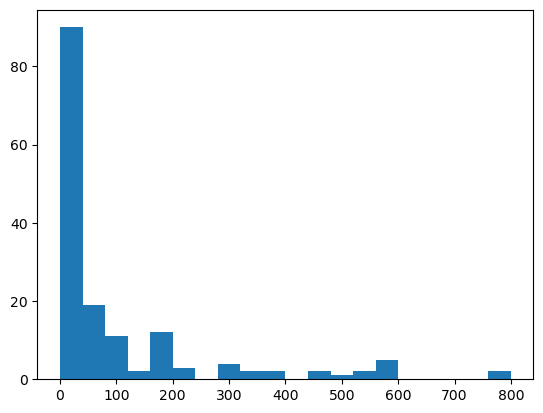

In [29]:
datacenters['power_capacity_mw'].describe()
plt.hist(datacenters['power_capacity_mw'], bins=20)

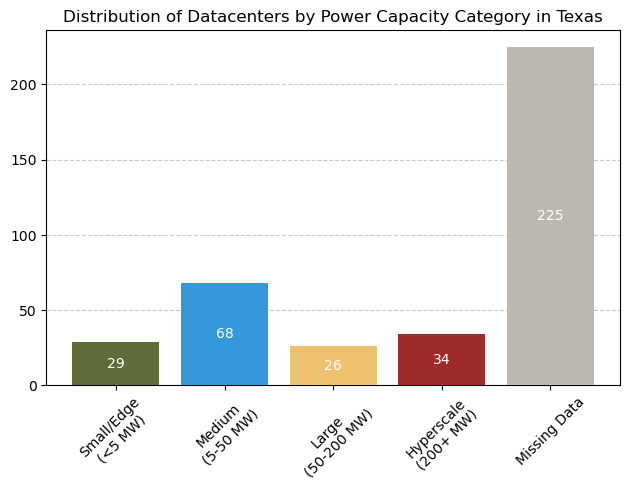

In [30]:
powercap_cat = datacenters['power_size_category'].value_counts()
order = ['Small/Edge (<5 MW)', 'Medium (5-50 MW)', 'Large (50-200 MW)', 'Hyperscale (200+ MW)', 'Missing Data']
labels = ['Small/Edge\n(<5 MW)', 'Medium\n(5-50 MW)', 'Large\n(50-200 MW)', 'Hyperscale\n(200+ MW)', 'Missing Data']
colors = ['#606c38', '#3498db', '#eec170', '#9e2a2b', '#bcb8b1']

ordered_values = [powercap_cat[cat] if cat in powercap_cat.index else 0 for cat in order]

plt.bar(labels, ordered_values, color=colors, zorder=3)
plt.bar_label(plt.gca().containers[0], label_type='center', color='white', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
plt.tight_layout()
plt.title('Distribution of Datacenters by Power Capacity Category in Texas')
plt.show()

(array([1.5749e+04, 1.5260e+03, 6.9200e+02, 5.1600e+02, 2.8500e+02,
        2.0000e+02, 1.6400e+02, 1.2000e+02, 3.2000e+01, 3.2000e+01,
        3.3000e+01, 2.2000e+01, 8.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.5000e+01, 1.7000e+01, 1.5000e+01]),
 array([ -17274. ,  182755.3,  382784.6,  582813.9,  782843.2,  982872.5,
        1182901.8, 1382931.1, 1582960.4, 1782989.7, 1983019. , 2183048.3,
        2383077.6, 2583106.9, 2783136.2, 2983165.5, 3183194.8, 3383224.1,
        3583253.4, 3783282.7, 3983312. ]),
 <BarContainer object of 20 artists>)

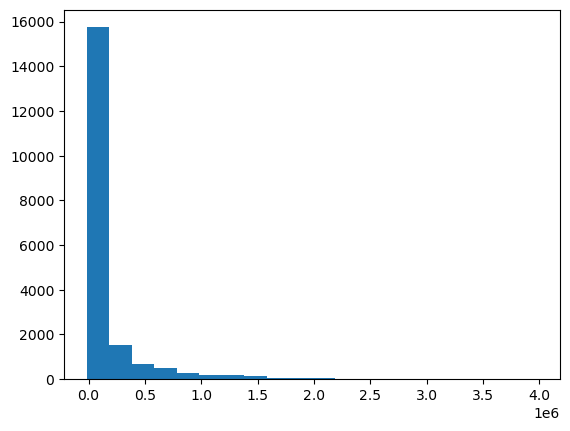

In [31]:
total_monthly_egen_by_fueltype['total_generation'].describe()
plt.hist(total_monthly_egen_by_fueltype['total_generation'], bins=20)

**Power Capacity**: Highly right-skewed distribution, representative of earlier bar plot that most facilities are small/medium (<50 MW), but hyperscale facilities (>200 MW) dominate total capacity.

**Total Generation**: Extremely right-skewed (most counties generate <500k MWh/month)

Shape... Structure... Data Types....

In [32]:
datacenter_agg_weather.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   datacenter                    382 non-null    object  
 1   operator                      382 non-null    object  
 2   address                       382 non-null    object  
 3   city                          382 non-null    object  
 4   postal_code                   382 non-null    object  
 5   county                        375 non-null    object  
 6   Solar Region                  375 non-null    object  
 7   Wind Region                   375 non-null    object  
 8   power_capacity_mw             157 non-null    float64 
 9   building_size_sqft            153 non-null    float64 
 10  whitespace_sqft               95 non-null     float64 
 11  whitespace_ratio              55 non-null     float64 
 12  geometry_x                    382 non-null

In [33]:
datacenter_agg_weather.describe()

,power_capacity_mw,building_size_sqft,whitespace_sqft,whitespace_ratio,latitude,longitude,wet_bulb_temperature_2m_mean,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_std,temperature_2m_mean,temperature_2m_max,precipitation_mean,precipitation_sum,relative_humidity_2m_mean
count,157.000000,1.530000e+02,9.500000e+01,55.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,105.214662,2.883839e+05,1.072790e+05,0.680820,31.524958,-97.426296,60.939541,83.711472,13.761098,69.636681,108.336678,0.005598,152.295502,64.413544
std,168.378474,4.709956e+05,1.997792e+05,0.575946,1.712292,1.822455,3.149624,2.153334,0.950886,2.057643,1.658055,0.001607,45.475723,6.777292
min,0.075000,1.500000e+03,1.500000e+03,0.084067,26.193490,-106.493388,49.251358,72.719528,10.182694,60.449760,98.474899,0.000778,21.035433,33.536457
25%,7.200000,5.000000e+04,2.500000e+04,0.386887,29.922817,-97.728497,59.522343,82.840637,12.868791,68.212553,107.024902,0.005031,136.090546,63.557842
50%,36.000000,1.300000e+05,4.850000e+04,0.533333,32.562113,-96.865574,60.267487,84.134571,14.391659,69.067360,108.640854,0.005993,162.102371,64.620430
75%,100.000000,3.500000e+05,1.030000e+05,0.861213,32.905120,-96.708717,62.616765,85.024410,14.545679,71.239330,109.369175,0.006468,174.937012,65.558405
max,800.000000,3.880000e+06,1.500000e+06,4.392000,35.485458,-95.037997,69.479065,87.015152,15.148311,76.681656,114.212296,0.008499,337.125977,78.462105


In [34]:
monthly_agg_county_fuel_mix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5864 entries, 0 to 5863
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   county                                5864 non-null   object  
 1   Solar Region                          5864 non-null   object  
 2   Wind Region                           5864 non-null   object  
 3   geometry                              5864 non-null   geometry
 4   period                                5793 non-null   object  
 5   Coal_gen_total                        5793 non-null   float64 
 6   Distillate Fuel Oil_gen_total         5793 non-null   float64 
 7   Hydroelectric Conventional_gen_total  5793 non-null   float64 
 8   Municiapl Landfill Gas_gen_total      5793 non-null   float64 
 9   Natural Gas_gen_total                 5793 non-null   float64 
 10  Nuclear_gen_total                     5793 non-null   float64 
 

In [35]:
monthly_agg_county_fuel_mix.describe()
county_fuel_null = monthly_agg_county_fuel_mix.isna().sum()
print(county_fuel_null)

county                                    0
Solar Region                              0
Wind Region                               0
geometry                                  0
period                                   71
Coal_gen_total                           71
Distillate Fuel Oil_gen_total            71
Hydroelectric Conventional_gen_total     71
Municiapl Landfill Gas_gen_total         71
Natural Gas_gen_total                    71
Nuclear_gen_total                        71
Other_gen_total                          71
Other Gases_gen_total                    71
Petroleum Coke_gen_total                 71
Residual Fuel Oil_gen_total              71
Solar_gen_total                          71
Waste Oil and Other Oils_gen_total       71
Wind_gen_total                           71
Wood Waste Solids_gen_total              71
other renewables_gen_total               71
total_generation                         71
Coal_gen_pct                            164
Distillate Fuel Oil_gen_pct     

In [36]:
dc_weather_null = datacenter_agg_weather.isna().sum()
print(dc_weather_null)

datacenter                        0
operator                          0
address                           0
city                              0
postal_code                       0
county                            7
Solar Region                      7
Wind Region                       7
power_capacity_mw               225
building_size_sqft              229
whitespace_sqft                 287
whitespace_ratio                327
geometry_x                        0
latitude                          0
longitude                         0
power_size_category               0
wet_bulb_temperature_2m_mean      0
wet_bulb_temperature_2m_max       0
wet_bulb_temperature_2m_std       0
temperature_2m_mean               0
temperature_2m_max                0
precipitation_mean                0
precipitation_sum                 0
relative_humidity_2m_mean         0
geometry_y                        0
dtype: int64


Testing for Normality: Q-Q PLot


Analyzing dataset: datacenter_agg_weather


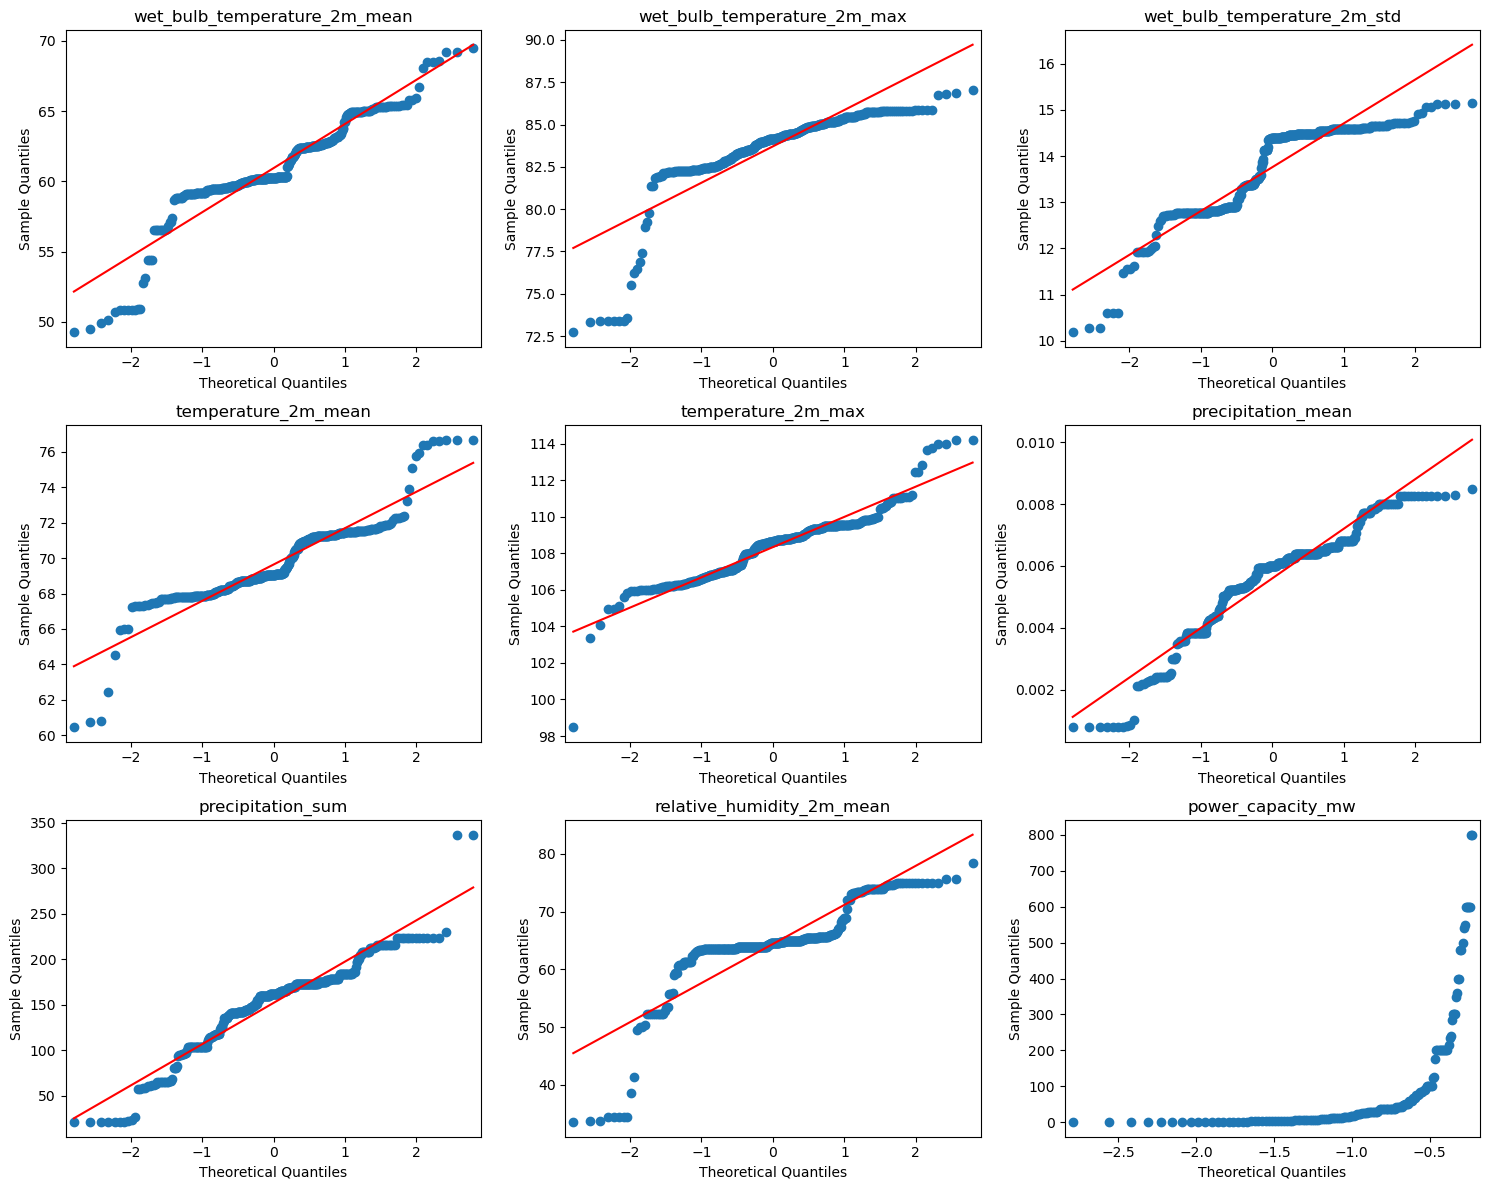


Analyzing dataset: county_fuel


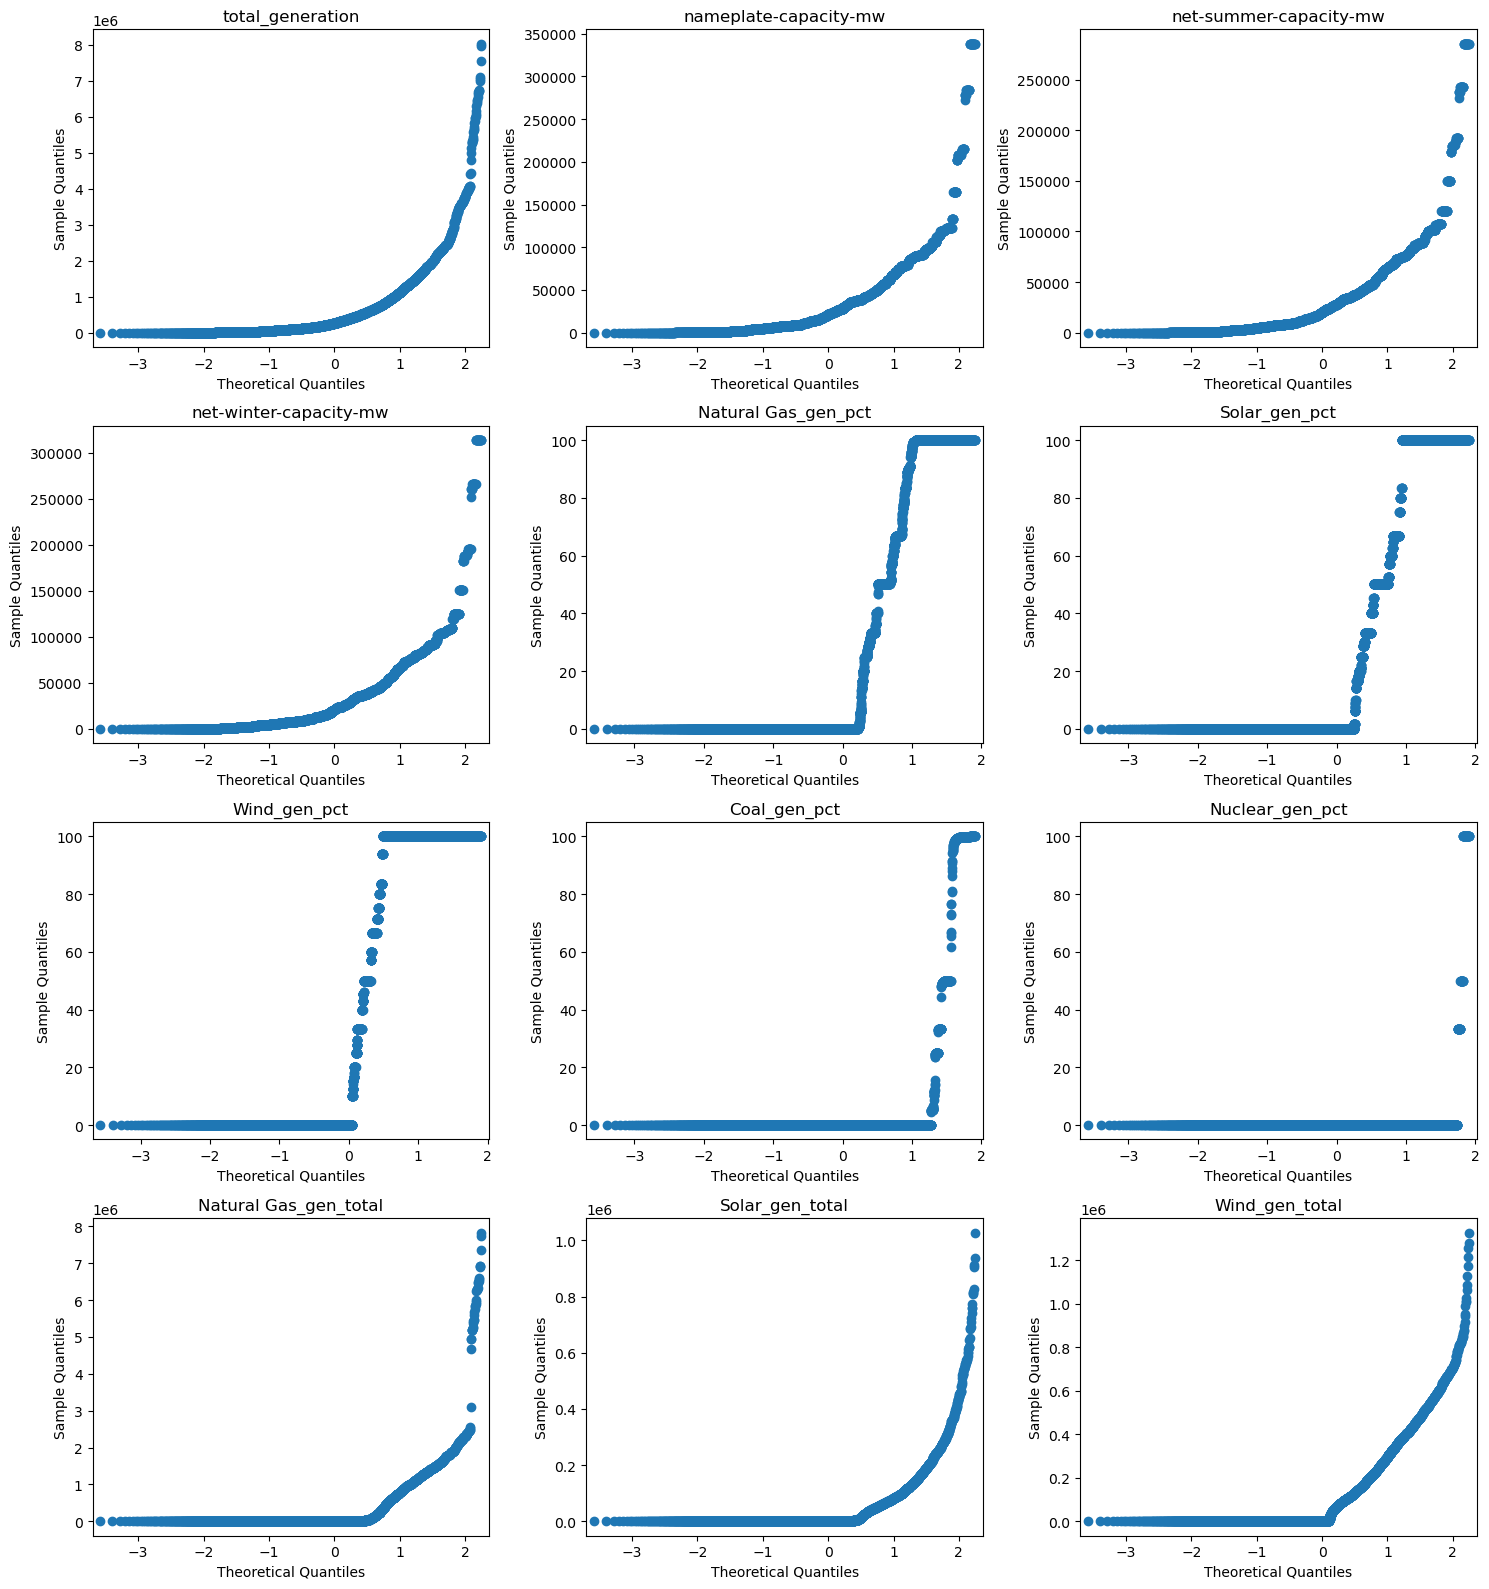

In [37]:
# Variables to test for normality
variables_to_test = {
    # Data Center Weather Variables
    'datacenter_agg_weather': [
        'wet_bulb_temperature_2m_mean',
        'wet_bulb_temperature_2m_max',
        'wet_bulb_temperature_2m_std',
        'temperature_2m_mean',
        'temperature_2m_max',
        'precipitation_mean',
        'precipitation_sum',
        'relative_humidity_2m_mean',
        'power_capacity_mw'],
    
    # County-Level Fuel Mix
    'county_fuel': [
        'total_generation', 'nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw',
        'Natural Gas_gen_pct',
        'Solar_gen_pct',
        'Wind_gen_pct',
        'Coal_gen_pct',
        'Nuclear_gen_pct',
        'Natural Gas_gen_total',
        'Solar_gen_total',
        'Wind_gen_total']}
df = {'datacenter_agg_weather': datacenter_agg_weather, 'county_fuel': monthly_agg_county_fuel_mix}

for dataset_name, variables in variables_to_test.items():
    current_df = df[dataset_name]
    n_vars = len(variables)
    n_cols = 3  # number of plots per row
    n_rows = -(-n_vars // n_cols) # ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # flatten in case of multiple rows
    
    print(f"\nAnalyzing dataset: {dataset_name}")
    
    for i, var in enumerate(variables):
        sm.qqplot(current_df[var], line='s', ax=axes[i])
        axes[i].set_title(var)
    
    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

Q-Q Plot Results Summary

- The `wet_bulb` variables all exhibit a step pattern that needs to be normalized before incorporating into modeling.  
- Both `power_capacity_mw` and `total_generation` appear highly skewed and need log transformation.
- The fuel_mix_pct variables and particular weather variables, such as `precipitation_sum`, also appeared slightly/moderately skewed and could perhaps use square root transformation or other methods. 

Transformations

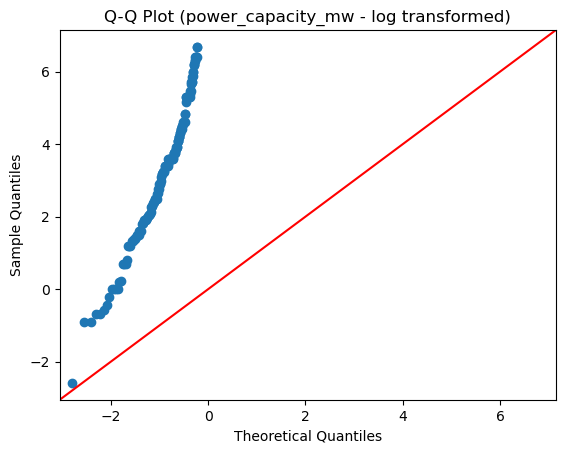

In [40]:
datacenter_agg_weather['dc_capacity_log'] = np.log(datacenter_agg_weather['power_capacity_mw'])  # log-transform with offset to avoid log(0)

sm.qqplot(datacenter_agg_weather["dc_capacity_log"], line='45') # setup for the QQ plot selecting the data column and 45 degree line
plt.title("Q-Q Plot (power_capacity_mw - log transformed)") # add title to the plot
plt.show()

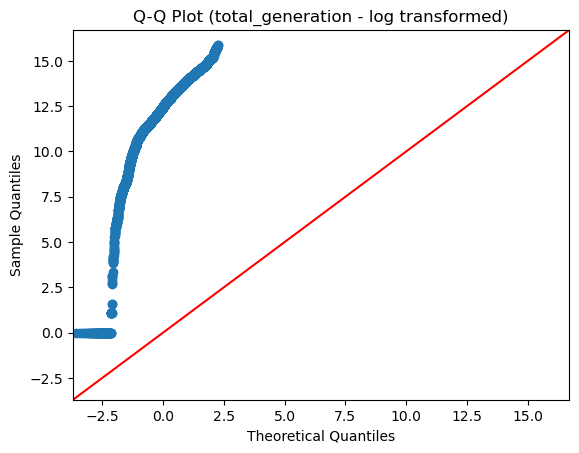

In [39]:
monthly_agg_county_fuel_mix['total_generation_log'] = np.log(monthly_agg_county_fuel_mix['total_generation'] + 1)  # log-transform with offset to avoid log(0)
sm.qqplot(monthly_agg_county_fuel_mix["total_generation_log"], line='45') # setup for the QQ plot selecting the data column and 45 degree line
plt.title("Q-Q Plot (total_generation - log transformed)") # add title to the plot
plt.show()

Testing for Potential Relationships: Correlation Matrices

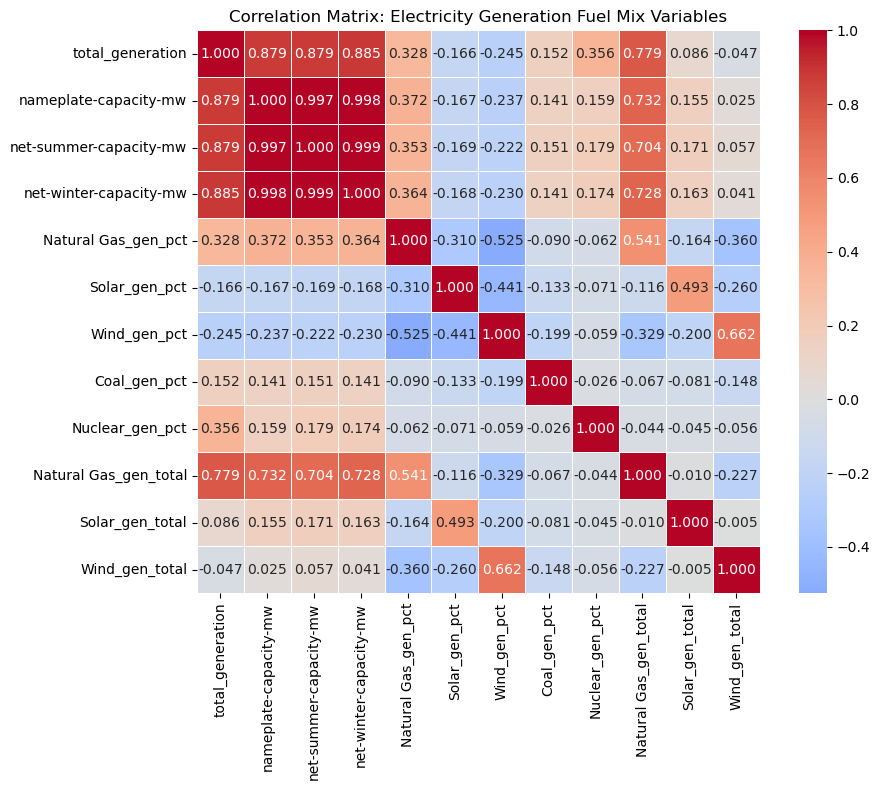

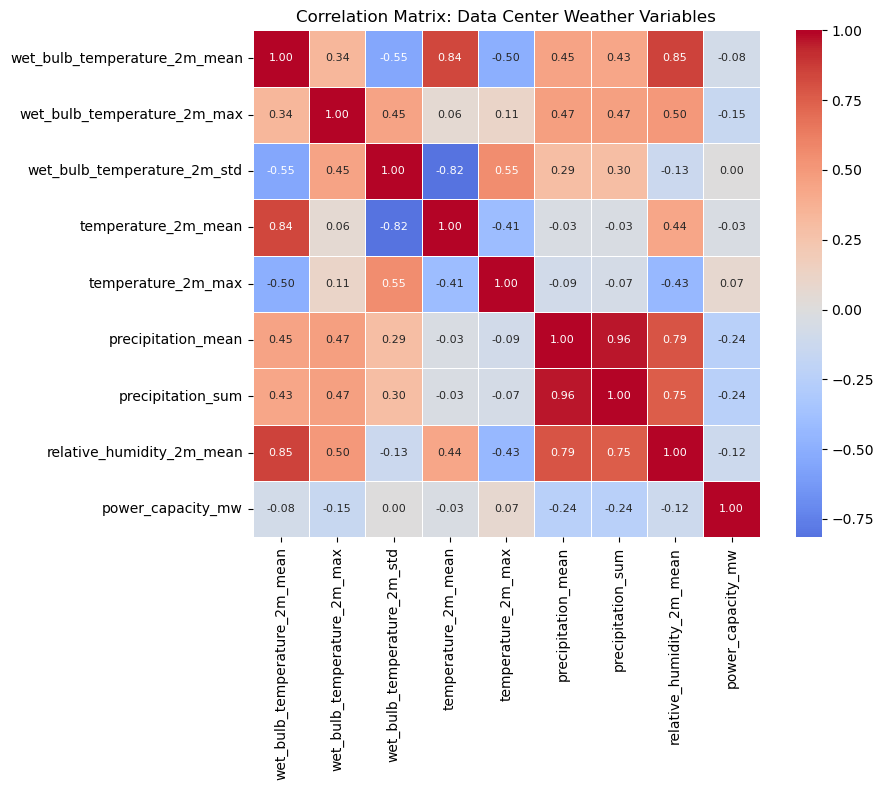

In [41]:
# Create correlation matrix for monthly_agg_county_fuel_mix variables
fuel_corr = monthly_agg_county_fuel_mix[[
    'total_generation', 
    'nameplate-capacity-mw', 
    'net-summer-capacity-mw', 
    'net-winter-capacity-mw',
    'Natural Gas_gen_pct',
    'Solar_gen_pct',
    'Wind_gen_pct',
    'Coal_gen_pct',
    'Nuclear_gen_pct',
    'Natural Gas_gen_total',
    'Solar_gen_total',
    'Wind_gen_total']].corr()

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(fuel_corr, 
            annot=True,           # Show correlation values
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            linewidths=0.5,       # Lines between cells
            fmt='.3f')            # 3 decimal places

plt.title('Correlation Matrix: Electricity Generation Fuel Mix Variables')
plt.tight_layout()
plt.show()

# Create correlation matrix for datacenter_agg_weather variables
weather_corr = datacenter_agg_weather[[
    'wet_bulb_temperature_2m_mean',
    'wet_bulb_temperature_2m_max',
    'wet_bulb_temperature_2m_std',
    'temperature_2m_mean',
    'temperature_2m_max',
    'precipitation_mean',
    'precipitation_sum',
    'relative_humidity_2m_mean',
    'power_capacity_mw'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(weather_corr, 
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('Correlation Matrix: Data Center Weather Variables')
plt.tight_layout()
plt.show()


#### Spatial EDA

/tmp/ipykernel_12389/191030677.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outside_tx = big_box.difference(tx_boundary.unary_union)
/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'Data Centers and Electricity Generation Plants in Texas')

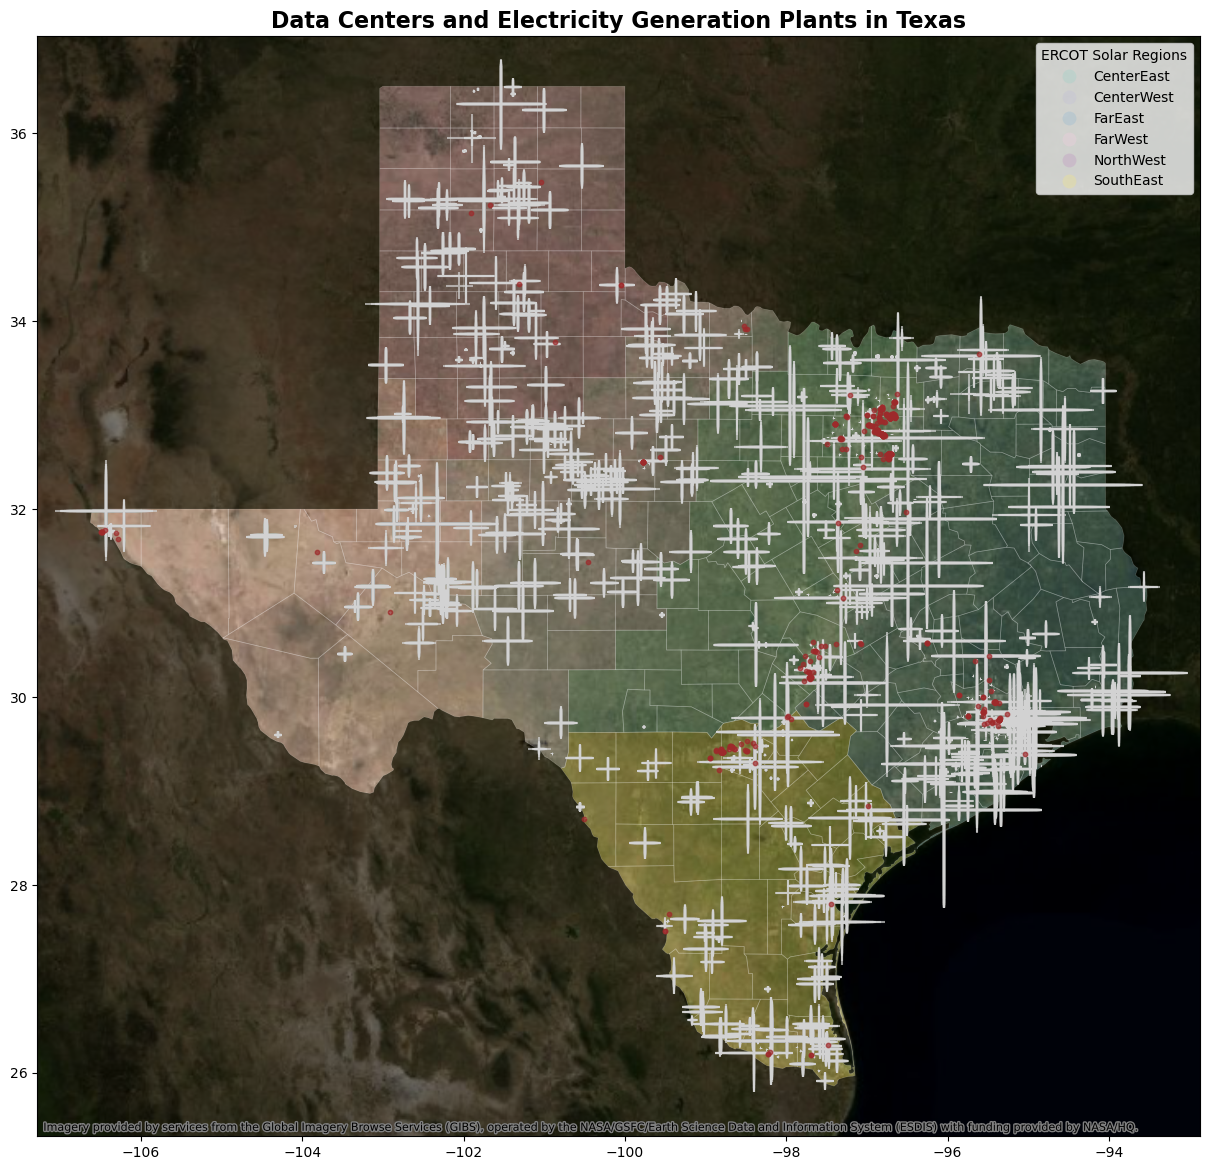

In [47]:
# Visualize Ercot Regions with Power Plants and Datacenters
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
#tx_counties.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)
counties_gdf.plot(column='Solar Region', ax=ax, alpha=0.25, legend=True, cmap='Set3', edgecolor= 'white', linewidth=0.5, legend_kwds={'title': 'ERCOT Solar Regions'})

ctx.add_basemap(ax = ax, crs = tx_counties.crs, source = ctx.providers.NASAGIBS.BlueMarble)

#Add mask
tx_boundary = tx_counties.dissolve()
big_box = box(tx_counties.total_bounds[0]-100000, tx_counties.total_bounds[1]-100000, tx_counties.total_bounds[2]+100000, tx_counties.total_bounds[3]+100000)
outside_tx = big_box.difference(tx_boundary.unary_union)
gpd.GeoSeries([outside_tx], crs='EPSG:3857').plot(ax=ax, color='black', alpha=0.5, zorder=5)

# Plot power plants by total generation
power_plants_gdf = gpd.GeoDataFrame(total_monthly_egen_by_fueltype, geometry=total_monthly_egen_by_fueltype['geometry'], crs='EPSG:4326')
# power_plants_gdf = power_plants_gdf.to_crs(tx_counties.crs)
power_plants_gdf.plot(ax=ax, color = 'lightgrey', markersize = power_plants_gdf['total_generation'] * 0.005, legend=True, marker = '+', alpha=0.7, 
                      legend_kwds={'label': 'Total Electricity Generation (MWh)', 'orientation': 'vertical', 'shrink': 0.7}, zorder=8)

tx_datacenters_gdf.plot(ax=ax, color='#9e2a2b', markersize= 10, alpha=0.7, edgecolor='#9e2a2b', label='Datacenters', zorder=10)       
ax.set_title('Data Centers and Electricity Generation Plants in Texas', fontsize=16, fontweight='bold')

Global Moran's I

In [ ]:
datacenter_agg_weather = datacenter_agg_weather.set_geometry('geometry_x')

In [67]:
datacenter_agg_weather = datacenter_agg_weather.to_crs(epsg=3857)

In [68]:
datacenter_agg_weather = datacenter_agg_weather.dropna(subset=['wet_bulb_temperature_2m_max', 'wet_bulb_temperature_2m_std'])
#  Create spatial weights matrix we will use the k-nearest neighbors)
w = ps.weights.KNN.from_dataframe(datacenter_agg_weather, k=8) # k is the number of nearest neighbors we want to use in the comparison, here
w.transform = 'r' # row-standardize the weights

# Calculate Moran's I for Max Values of Wet Bulb Temperature
moran_wet_bulb_max = Moran(datacenter_agg_weather['wet_bulb_temperature_2m_max'], w) #This sets up a Moran's I analysis of the CMDEV data
print(f"Moran's I for Max of Wetbulb Temperature variable: {moran_wet_bulb_max.I:.4f}")
#The print statement above is: moran_wet_bulb.I return the moran I's value; abbreviate the value at four decimal places and format as a
print(f"Expected I: {moran_wet_bulb_max.EI:.4f}") #Expected I
print(f"p-value: {moran_wet_bulb_max.p_norm:.4f}")#p-value
print(f"z-score: {moran_wet_bulb_max.z_norm:.4f}")#z-score

# Calculate Moran's I for Standard Deviation of Wet Bulb Temperature
moran_wet_bulb_std = Moran(datacenter_agg_weather['wet_bulb_temperature_2m_std'], w) #This sets up a Moran's I analysis of the RM data
#breakdown of the following code is the same as above
print(f"\nMoran's I for Standard Deviation of Wet Bulb Temperature variable: {moran_wet_bulb_std.I:.4f}")
print(f"Expected I: {moran_wet_bulb_std.EI:.4f}")
print(f"p-value: {moran_wet_bulb_std.p_norm:.4f}")
print(f"z-score: {moran_wet_bulb_std.z_norm:.4f}")

Moran's I for Max of Wetbulb Temperature variable: 0.8805
Expected I: -0.0026
p-value: 0.0000
z-score: 37.9385

Moran's I for Standard Deviation of Wet Bulb Temperature variable: 0.9611
Expected I: -0.0026
p-value: 0.0000
z-score: 41.3993


/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


LISA (Local Moran's I)

In [70]:
# Compute Spatial Weights
k = 10
w = ps.weights.KNN.from_dataframe(datacenter_agg_weather, k=k)
w.transform = 'r'

# Compute LISA
y = datacenter_agg_weather['wet_bulb_temperature_2m_mean'].values
lisa_wet_bulb = Moran_Local(y, w, permutations=999)

/home/shalini/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [71]:
# Save LISA results to DataFrame
datacenter_agg_weather['lisa_I'] = lisa_wet_bulb.Is                  # Local I statistics
datacenter_agg_weather['lisa_p'] = lisa_wet_bulb.p_sim             # Permutation-based p-values
datacenter_agg_weather['lisa_q'] = lisa_wet_bulb.q                # Quadrant location: 1=HH, 2=LH, 3=LL, 4=HL

Visualize Moran's I and LISA on Texas Counties Map

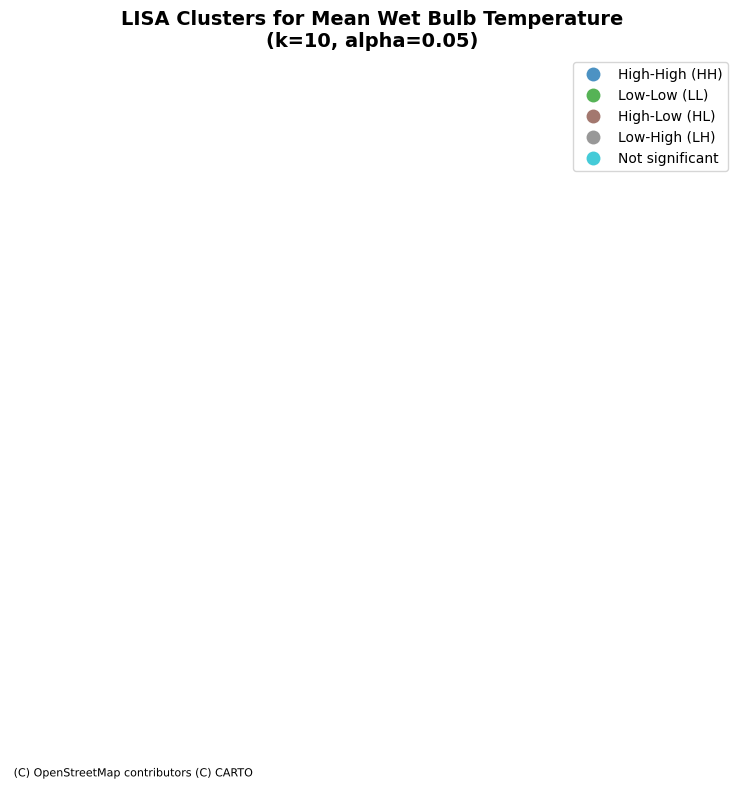

In [78]:
# define cluster labels with significance at 0.05 alpha level
alpha = 0.05 #This is not transparecny, it is the alpha level for the statistical significance test
signif = datacenter_agg_weather["lisa_p"] < alpha
# here we use the else,if, elif to create categories of the LISA statistic results. The classification is described below
def label_from_q(row):
    if not row["lisa_p"] < alpha:
        return "Not significant"
    q = int(row["lisa_q"]) #lisa q is the quadrant
    # Common categorical divisions for Moran_Local.q:
    # 1 = High-High (HH)
    # 2 = Low-High (LH) -> low value surrounded by high neighbors (spatial outlier)
    # 3 = Low-Low (LL)
    # 4 = High-Low (HL) -> high value surrounded by low neighbors (spatial outlier)
    if q == 1:
        return "High-High (HH)"
    elif q == 2:
        return "Low-High (LH)"
    elif q == 3:
        return "Low-Low (LL)"
    elif q == 4:
        return "High-Low (HL)"
    else:
        return "Other"
datacenter_agg_weather["lisa_cluster"] = datacenter_agg_weather.apply(label_from_q, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
category_order = ["High-High (HH)", "Low-Low (LL)", "High-Low (HL)", "Low-High (LH)", "Not significant"]
# create a categorical column with ordered categories for consistent plotting
datacenter_agg_weather["lisa_cluster"] = pd.Categorical(datacenter_agg_weather["lisa_cluster"], categories=category_order)
# Plot: choose a colormap yourself if desired; here we let geopandas use its defaults


ctx.add_basemap(ax = ax, crs = datacenter_agg_weather.crs , source = ctx.providers.CartoDB.Positron, zoom=6, zorder=1)

datacenter_agg_weather.plot(column="lisa_cluster", categorical=True, legend=True, markersize=20, alpha=0.8, ax=ax, zorder=20)
ax.set_title(f'LISA Clusters for Mean Wet Bulb Temperature\n(k={k}, alpha={alpha})', fontsize=14, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
# LISA Cluster Map

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
tx_counties.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.3)

# Create categorical column with ordered categories
category_order = ["High-High (HH)", "Low-Low (LL)", "High-Low (HL)", "Low-High (LH)", "Not significant"]
datacenter_agg_weather["lisa_cluster"] = pd.Categorical(
    datacenter_agg_weather["lisa_cluster"], 
    categories=category_order, 
    ordered=True)

# # Convert to CRS matching Texas counties if needed
# if datacenter_agg_weather.crs != tx_counties.crs:
#     datacenter_agg_weather_proj = datacenter_agg_weather.to_crs(tx_counties.crs)
# else:
#     datacenter_agg_weather_proj = datacenter_agg_weather

# Define custom colors for LISA categories
colors = {'High-High (HH)': '#d7191c',      # red
          'Low-Low (LL)': '#2b83ba',        # blue
          'High-Low (HL)': '#fdae61',       # orange
          'Low-High (LH)': '#abdda4',       # light green
          'Not significant': '#e0e0e0'}     # grey

# Plot LISA clusters
datacenter_agg_weather_proj.plot(column="lisa_cluster", categorical=True, 
                                legend=True, markersize=100, alpha=0.8, ax=ax,
                                cmap='RdYlBu_r', edgecolor='black', linewidth=0.5,
                                legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'title': 'LISA Cluster Type'})

ax.set_title(f'LISA Clusters for Mean Wet Bulb Temperature\n(k={k}, alpha={alpha})', fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()

### III. Create Training Dataset

### IV. Split into Training and Test Datasets

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(training_data, test_size=0.2, random_state=42)

GWR

In [ ]:
y = georgia_shp['PctBach'].values #outcome variable is percent bachelor degrees.
X = georgia_shp[['PctFB', 'PctBlack', 'PctRural']].values #predictor variables are percent forieng born, percent black residents, and percent rural residents
lon = georgia_shp['X'] #longitude
lat = georgia_shp['Y'] # latitude

coords = list(zip(lon,lat)) #create a list of latitude and longitude pairs. Zip function is used to create tuple pairs of lat,long

### V. Model Fitting

##### GWR (Geographically Weighted Regression)

In [ ]:
#Identify the optimal bandwidth
gwr_selector = Sel_BW(coords, y, X) #Sel_BW is an object of coordinates, and x,y values for the dataset. This format is needed for the .search function

gwr_bw = gwr_selector.search() #The .search() function is used to test different bandwidths. 

print("Selected optimal bandwidth is:", gwr_bw) #print the output of the function. 
#The value will be an integer representing the optimal bandwith, or number of points used in the estimate

### VI. Model Performance

### VII. Analysis (Visualizing Results)

<u> Limitations </u>
<br> Insert more here.  
<u> Next Steps </u> 
<br> Insert more info here.

## README

### Setup Requirements
1. **EIA Data**: https://api.eia.gov/v2/electricity/ (requires free API key at https://www.eia.gov/opendata/register.php)
2. **Weather Data**: https://archive-api.open-meteo.com/v1/archive (free, no key required)
3. **API Rate Limits**: Approximately 60-second delays between API batch requests for EIA and Open-Meteo
4. **Data Center Locations Scraper**: expected runtime is approximately 3 hours expected runtime for full data collection and saving to .csv files locally

### External Data Sources
```
/Texas Datacenter Siting Project
├── texas_datacenter_scraper.py
├── scraper_debug.py
├── https://www.datacentermap.com/usa/texas/
├── ERCOT Wind Regions to County Mapping.xlsx: https://www.ercot.com/files/docs/2024/05/31/Wind%20and%20Solar%20Regions%20to%20County%20Mapping.xlsx
├── ERCOT Solar Regions to County Mapping.xlsx: https://www.ercot.com/files/docs/2024/05/31/Wind%20and%20Solar%20Regions%20to%20County%20Mapping.xlsx
├── hourly_weather_data.csv: https://archive-api.open-meteo.com/v1/archive
├── geojson-counties-fips.json
└── 
```